# Import

In [1]:
import glob
import os
import sys
import random
import time
import numpy as np
import cv2
import math
from collections import deque
from keras.models import Sequential
from keras.applications.xception import Xception
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.models import Model
from keras.models import model_from_json
import pandas as pd
from plotnine import *
#from keras.callbacks import TensorBoard

import tensorflow as tf
import keras.backend.tensorflow_backend as backend
from threading import Thread
from tqdm import tqdm_notebook as tqdm

try:
    sys.path.append(glob.glob('../carla/dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass
import carla
print('IMPORT DONE')

Using TensorFlow backend.


IMPORT DONE


# Car Environment [Action/Reward here]

In [2]:
class CarEnv:
    #BRAKE_AMT = 1.0
    actor_list = []
    collision_hist = []
    pt_cloud = []
    pt_cloud_filtered = []
    
    def __init__(self):
        self.client = carla.Client('localhost', 2000)
        self.client.set_timeout(2.0)
        self.world = self.client.get_world()
        blueprint_library = self.world.get_blueprint_library()
        self.model_3 = blueprint_library.filter('model3')[0]
        self.truck_2 = blueprint_library.filter('carlamotors')[0]
        
    def Black_screen(self):
        settings = self.world.get_settings()
        settings.no_rendering_mode = True
        self.world.apply_settings(settings)
                     
    def reset(self):
        self.collision_hist = []
        self.actor_list = []
        self.pt_cloud = []
        self.pt_cloud_filtered = []
        place=random.uniform(110,150)
        ##print('Location: ',str(place))
        #transform = carla.Transform(carla.Location(-120,place,3),carla.Rotation(0,-90,0))
        transform = carla.Transform(carla.Location(246,-36,3),carla.Rotation(0,-90,0))        
        self.flag = 0
        self.vehicle = self.world.spawn_actor(self.model_3, transform)
        self.flag = 1
        
        self.actor_list.append(self.vehicle)
     

        self.lidar_sensor = self.world.get_blueprint_library().find('sensor.lidar.ray_cast')
        self.lidar_sensor.set_attribute('points_per_second', '100000')
        self.lidar_sensor.set_attribute('channels', '32')
        self.lidar_sensor.set_attribute('range', '10000')
        self.lidar_sensor.set_attribute('upper_fov', '10')
        self.lidar_sensor.set_attribute('lower_fov', '-10')
        self.lidar_sensor.set_attribute('rotation_frequency', '60')
        
        transform = carla.Transform(carla.Location(x=0, z=1.9))
        time.sleep(0.01)

        self.sensor = self.world.spawn_actor(self.lidar_sensor, transform, attach_to=self.vehicle)
     
        self.actor_list.append(self.sensor)
        self.sensor.listen(lambda data: self.process_lidar(data))

        self.vehicle.apply_control(carla.VehicleControl(throttle=1, brake=0.0))
        self.episode_start = time.time()
   
        time.sleep(0.4) # sleep to get things started and to not detect a collision when the car spawns/falls from sky.
        
        transform2 = carla.Transform(carla.Location(x=2.5, z=0.7))
        colsensor = self.world.get_blueprint_library().find('sensor.other.collision')
        self.colsensor = self.world.spawn_actor(colsensor, transform2, attach_to=self.vehicle)
        self.actor_list.append(self.colsensor)
        self.colsensor.listen(lambda event: self.collision_data(event))

        while self.distance_to_obstacle_f is None:
            time.sleep(0.01)

        self.episode_start = time.time()
        
        self.vehicle.apply_control(carla.VehicleControl(throttle=1, brake=0.0))
        
        ##SENSOR LIDAR
        xx = self.distance_to_obstacle_f
        yy = self.distance_to_obstacle_r
        zz = self.distance_to_obstacle_l
        state_=np.array([xx,yy,zz])
        
        return state_

    def collision_data(self, event):
        self.collision_hist.append(event)

    def process_lidar(self, raw):
        points = np.frombuffer(raw.raw_data, dtype=np.dtype('f4'))
        points = np.reshape(points, (int(points.shape[0] / 3), 3))*np.array([1,-1,-1])
        
        lidar_f = lidar_line(points,90,2)
        lidar_r = lidar_line(points,45,2)
        lidar_l = lidar_line(points,135,2)

        if len(lidar_f) == 0:
            pass
        else:
            self.distance_to_obstacle_f = min(lidar_f[:,1])-2.247148275375366
        
        if len(lidar_r) == 0:
            pass
        else:
            self.distance_to_obstacle_r = np.sqrt(min(lidar_r[:,0]**2 + lidar_r[:,1]**2))
        
        if len(lidar_l) == 0:
            pass
        else:
            self.distance_to_obstacle_l = np.sqrt(min(lidar_l[:,0]**2 + lidar_l[:,1]**2))
    

    def step(self, action):
        
        sleepy=0.2
        
        if action == 0:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = 0.3))
            time.sleep(sleepy)
            reward = 0.5
        elif action == 1:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = -0.3))
            time.sleep(sleepy)
            reward = 0.5
        elif action == 2 :
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = 0.0))
            time.sleep(sleepy)
            reward = 2  
        elif action == 3 :
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = 0.1))
            time.sleep(sleepy)
            reward = 1  
        elif action == 4 :
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = -0.1))
            time.sleep(sleepy)
            reward = 1  

        
        if len(self.collision_hist) != 0:
            done = True
            reward = -10
        else :
            done=False
            
        if self.episode_start + SECONDS_PER_EPISODE < time.time():
            done = True
            
        xx = self.distance_to_obstacle_f
        yy = self.distance_to_obstacle_r
        zz = self.distance_to_obstacle_l
        state_=np.array([xx,yy,zz])
            
        return state_, reward, done, None

# Optional Function

In [3]:
def open_carla():
    try:
        os.popen('C:\\Users\\nbhah\\Desktop\\Carla\\CarlaUE4\\Binaries\\Win64\\CarlaUE4.exe -benchmark  -fps=10 -quality-level=Lo')
        #os.popen('C:\\Users\\nbhah\\Desktop\\Carla\\CarlaUE4\\Binaries\\Win64\\CarlaUE4.exe')
    except Exception as err:
        print(err)
    print('opening Carla')
    
def close_carla():
    try:
        os.system('TASKKILL /F /IM CarlaUE4.exe')
    except Exception as err:
        print(err)
    time.sleep(0.5)
    
def xxx():
    env.world.wait_for_tick()
    for x in list(env.world.get_actors()):
        if x.type_id == 'vehicle.tesla.model3' or x.type_id == 'sensor.lidar.ray_cast' or x.type_id == 'sensor.other.collision':
            x.destroy()
            
def lidar_line(points,degree,width):
    angle = degree*(2*np.pi)/360
    points_l = points
    points_l = points_l[np.logical_and(points_l[:,2] > -1.75, points_l[:,2] < 1000)] #z
    points_l = points_l[np.logical_and(np.tan(angle)*points_l[:,0]+width*np.sqrt(1+np.tan(angle)**2)>=points_l[:,1], np.tan(angle)*points_l[:,0]-width*np.sqrt(1+np.tan(angle)**2)<=points_l[:,1])] #y
    if 180>degree >0:
        points_l = points_l[np.logical_and(points_l[:,1]>0, points_l[:,1]<1000)] #y>0
    if 180<degree<360:
        points_l = points_l[np.logical_and(points_l[:,1]<0, points_l[:,1] > -1000)] #x
    if degree == 0 or degree == 360:
        points_l = points_l[np.logical_and(points_l[:,0]>0,points_l[:,0] <1000 )] #x
    if degree == 180:
        points_l = points_l[np.logical_and(points_l[:,0] >-1000 , points_l[:,0]<0 )]
    return  points_l

# DQN Algorithm

In [4]:
class DQNAgent:
    
    def __init__(self,state_size,action_size):
        self.state_size=state_size
        self.action_size=action_size
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

        self.target_update_counter = 0
        #self.graph = tf.get_default_graph()

        self.terminate = False
        self.last_logged_episode = 0
        self.training_initialized = False
    
    def get_weight(self):
        
        w = self.model.get_weights()        
        return w
    
    def predict(self,state):
        predict = predict = self.model.predict(state.reshape((1, self.state_size)))
        return predict
    
    def save_model(self,name):
        model_json = self.model.to_json()
        with open("{}.json".format(name), "w") as json_file:
            json_file.write(model_json)
        self.model.save_weights("{}_model.h5".format(name))
        print("Saved model to disk")     
        

    def create_model(self):
        
        model = Sequential()
        model.add(Dense(32, input_dim=self.state_size, activation='relu'))
        model.add(Dense(64, input_dim=32, activation='relu')) 
        model.add(Dense(self.action_size, activation='linear'))            # output nodes = #action
        model.compile(loss='mse', optimizer=Adam(lr=0.01))
        return model

    def update_replay_memory(self, transition):
        # transition = (current_state, action, reward, new_state, done)
        self.replay_memory.append(transition)

    def train(self):
        global Loss
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            self.terminate=True
            Loss.append(0)
            return

        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)
        
        current_states = np.array([transition[0] for transition in minibatch])
        
        #with self.graph.as_default():
        current_qs_list = self.model.predict(current_states, PREDICTION_BATCH_SIZE)

        new_current_states = np.array([transition[3] for transition in minibatch])
        
        #with self.graph.as_default():
        future_qs_list = self.target_model.predict(new_current_states, PREDICTION_BATCH_SIZE)

        X = []
        y = []

        for index, (current_state, action, reward, new_state, done) in enumerate(minibatch):
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward

            current_qs = current_qs_list[index]
            current_qs[action] = new_q
            
            X.append(current_state)
            y.append(current_qs)


        history=self.model.fit(np.array(X), np.array(y), batch_size=TRAINING_BATCH_SIZE, verbose=0, shuffle=False)
        history
        Loss.append(history.history['loss'][0])

    def get_qs(self, state):
        return self.model.predict(state.reshape((1, self.state_size)))[0]
        
    def train_in_loop(self):
        X = np.random.uniform(size=(1, self.state_size)).astype(np.float32)
        y = np.random.uniform(size=(1, self.action_size)).astype(np.float32)
        
        self.model.fit(X,y, verbose=False, batch_size=1)

        self.training_initialized = True
        print('Start Train')
        while True:
            if self.terminate:
                return
            self.train()
            time.sleep(0.01)

# Input

In [5]:
SECONDS_PER_EPISODE = 10
REPLAY_MEMORY_SIZE = 5_000
MIN_REPLAY_MEMORY_SIZE = 32
MINIBATCH_SIZE = 32
PREDICTION_BATCH_SIZE = 1
TRAINING_BATCH_SIZE = MINIBATCH_SIZE // 4
UPDATE_TARGET_EVERY = 5


MEMORY_FRACTION = 0.4
MIN_REWARD = -200

EPISODES = 10

DISCOUNT = 0.99
epsilon = 1
EPSILON_DECAY = 0.99975 ## 0.9975 99975
MIN_EPSILON = 0.001

AGGREGATE_STATS_EVERY = 10
state_size=3
action_size=5

# MAIN

In [6]:
if __name__ == '__main__':
    close_carla()    
    open_carla()
    time.sleep(15)
    FPS=60

    ep_rewards = []
    ep=[]
    Step=[]
    Loss=[]

    # For more repetitive results
    random.seed(1)
    np.random.seed(1)
    #tf.random.set_seed(1)

    #Memory fraction, used mostly when trai8ning multiple agents
    #gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=MEMORY_FRACTION)
    #backend.set_session(tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)))

    # Create models folder
    #if not os.path.isdir('models'):
    #    os.makedirs('models')
   
    # Create agent and environment
    agent = DQNAgent(state_size,action_size)
    env = CarEnv()
    env.Black_screen()
    xxx()
  
    agent.train_in_loop()
    agent.get_qs(np.ones((1, 3)))

    # Iterate over episodes
    with tqdm(total=EPISODES) as pbar:
        
        for episode in range(EPISODES):
            
            #try:

            env.collision_hist = []
            episode_reward = 0
            loss=0
            step = 1

            # Reset environment and get initial state
            current_state = env.reset()

            # Reset flag and start iterating until episode ends
            done = False
            episode_start = time.time()

            # Play for given number of seconds only
            while True:

                # This part stays mostly the same, the change is to query a model for Q values
                if np.random.random() > epsilon:
                    # Get action from Q table
                    action = np.argmax(agent.get_qs(current_state))
                else:
                    # Get random action
                    action = np.random.randint(0, action_size)
                    # This takes no time, so we add a delay matching 60 FPS (prediction above takes longer)
                    time.sleep(1/FPS)

                new_state, reward, done, _ = env.step(action)

                # Transform new continous state to new discrete state and count reward
                episode_reward += reward
             
                # Every step we update replay memory
                agent.update_replay_memory((current_state, action, reward, new_state, done))
                current_state = new_state
                step += 1

                if done:
                    break
                    
            # End of episode - destroy agents
            for actor in env.actor_list:
                actor.destroy()
            agent.train()
            
            # Decay epsilon
            if epsilon > MIN_EPSILON:
                epsilon *= EPSILON_DECAY
                epsilon = max(MIN_EPSILON, epsilon)
                
            print('Episode :{}, Step :{}, Epsilon :{} ,Reward :{}'\
                  .format(episode,step,epsilon,episode_reward))
            
            ep_rewards.append(episode_reward)
            ep.append(episode)
            Step.append(step)
            
            pbar.update(1)
    close_carla()       
   

opening Carla
Start Train


Episode :0, Step :5, Epsilon :0.99975 ,Reward :-7.0
Episode :1, Step :6, Epsilon :0.9995000625 ,Reward :-6.0
Episode :2, Step :4, Epsilon :0.999250187484375 ,Reward :-8.5
Episode :3, Step :5, Epsilon :0.9990003749375039 ,Reward :-7.5
Episode :4, Step :5, Epsilon :0.9987506248437695 ,Reward :-6.5
Episode :5, Step :5, Epsilon :0.9985009371875586 ,Reward :-7.0
Episode :6, Step :6, Epsilon :0.9982513119532618 ,Reward :-7.0
Episode :7, Step :4, Epsilon :0.9980017491252735 ,Reward :-8.5
Episode :8, Step :5, Epsilon :0.9977522486879922 ,Reward :-7
Episode :9, Step :6, Epsilon :0.9975028106258202 ,Reward :-7.5



# Graph

In [7]:
df=pd.DataFrame({'Episode':ep,'Reward':ep_rewards,'Step':Step,'Loss':Loss[1:]})
df

,Episode,Reward,Step,Loss
0,0,-7.0,5,0.000000
1,1,-6.0,6,0.000000
2,2,-8.5,4,0.000000
3,3,-7.5,5,0.000000
4,4,-6.5,5,0.000000
5,5,-7.0,5,0.000000
6,6,-7.0,6,0.000000
7,7,-8.5,4,16.958256
8,8,-7.0,5,11.428303
9,9,-7.5,6,7.804197


In [8]:
df.describe()

,Episode,Reward,Step,Loss
count,10.00000,10.000000,10.000000,10.000000
mean,4.50000,-7.250000,5.100000,3.619076
std,3.02765,0.790569,0.737865,6.219298
min,0.00000,-8.500000,4.000000,0.000000
25%,2.25000,-7.500000,5.000000,0.000000
50%,4.50000,-7.000000,5.000000,0.000000
75%,6.75000,-7.000000,5.750000,5.853148
max,9.00000,-6.000000,6.000000,16.958256


C:\Users\nbhah\Anaconda3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


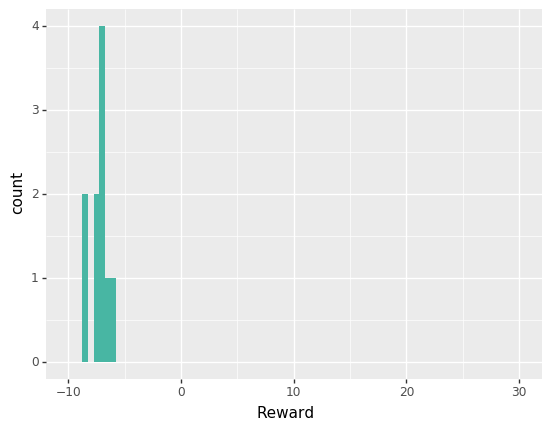

<ggplot: (76745205547)>

In [9]:
ggplot(df,aes(x='Reward'))+\
geom_histogram(binwidth=0.5,fill='#48b6a3')+\
xlim(-10,30)

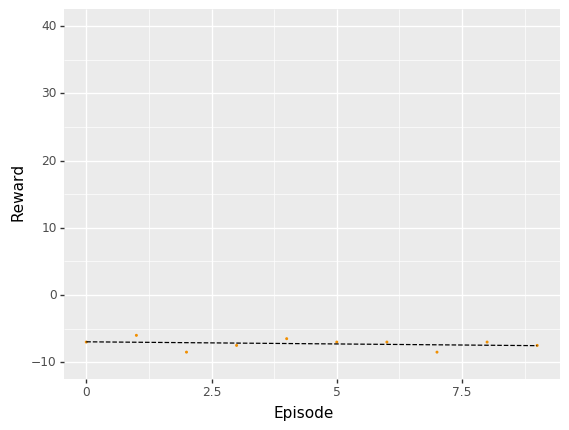

<ggplot: (-9223371960108594849)>

In [10]:
ggplot(df, aes(x='Episode',y='Reward'))+ \
  geom_point(color="#F18F01", size=0.2)+\
    geom_smooth(method="lm", se=False, size=0.5, linetype="dashed")+\
        ylim(-10,40)

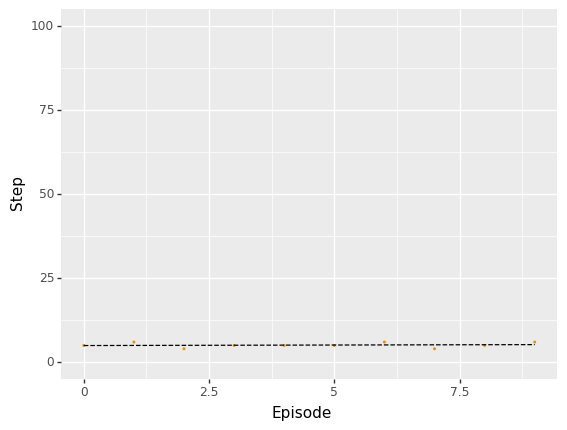

<ggplot: (-9223371960108589894)>

In [11]:
ggplot(df, aes(x='Episode',y='Step'))+ \
  geom_point(color="#F18F01", size=0.2)+\
    geom_smooth(method="lm", se=False, size=0.5, linetype="dashed")+\
        ylim(0,100)

C:\Users\nbhah\Anaconda3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 3 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


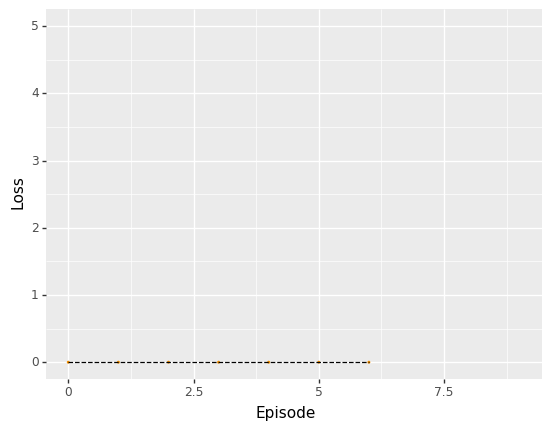

<ggplot: (-9223371960108650808)>

In [12]:
ggplot(df, aes(x='Episode',y='Loss'))+ \
  geom_point(color="#F18F01", size=0.2)+\
    geom_smooth(method="lm", se=False, size=0.5, linetype="dashed")+\
        ylim(0,5)

# Save data and model

In [13]:
name='Test' ##INSERT FILE NAME
file_path="DATA\\ "
df.to_csv(file_path+'{}.csv'.format(name))
agent.save_model(file_path+name)

Saved model to disk
